# 🧠 Brain Tumor Detection Using Deep Learning

This project uses a Convolutional Neural Network (CNN) to classify MRI brain scans into different tumor categories.  
The goal is to assist in early diagnosis using AI-powered medical image analysis.


### 🔹 Step 1: Importing Required Libraries
In this step, I imported all the necessary deep learning and data processing libraries such as TensorFlow, Keras, NumPy, OpenCV, and Matplotlib. These libraries help in building the CNN model, preprocessing MRI images, training the network, and visualizing the results.


In [5]:
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
import itertools


### 🔹 Step 2: Loading MRI Dataset
Here, I used `image_dataset_from_directory()` to load the MRI brain scan images directly from folders. This method automatically assigns class labels based on folder names and prepares the data for training and testing.


In [6]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
train_generator = tf.keras.utils.image_dataset_from_directory(directory=r"C:\Users\Acer\Downloads\Braintumor\training",
                                               image_size=(256,256))
test_generator = tf.keras.utils.image_dataset_from_directory(directory=r"C:\Users\Acer\Downloads\Braintumor\testing",
                                              image_size=(256,256))

# Save class names before applying .map(), since MapDataset doesn't expose .class_names
dataset_class_names = train_generator.class_names
det_test_clss_nms = test_generator.class_names

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])


# EfficientNet preprocessing
train_generator = train_generator.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_generator = test_generator.map(lambda x, y: (preprocess_input(x), y))

# Speed up pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_generator = train_generator.cache().shuffle(1000).prefetch(AUTOTUNE)
test_generator = test_generator.cache().prefetch(AUTOTUNE)


print(det_test_clss_nms, dataset_class_names)

Found 12345 files belonging to 4 classes.
Found 3049 files belonging to 4 classes.
['glioma', 'meningioma', 'notumor', 'pituitary'] ['glioma', 'meningioma', 'notumor', 'pituitary']


### 🔹 Step 3: Building the CNN Model
In this step, I created a Convolutional Neural Network (CNN) using Keras Sequential API. The model consists of convolution layers for feature extraction, pooling layers for dimensionality reduction, and dense layers for classification.


In [7]:
from tensorflow.keras.applications import EfficientNetB0
base_model=EfficientNetB0(include_top=False,weights="imagenet",input_shape=(256,256,3))
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

base_model.trainable=True
for layers in base_model.layers[:-30]:
    layers.trainable=False
model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),

    Dense(256,activation="relu"),
    Dropout(0.4),
    Dense(4,activation="softmax")
])
model.compile(optimizer=Adam(learning_rate=0.0001),loss="sparse_categorical_crossentropy",metrics=["accuracy"])


### 🔹 Step 4: Training the Model
Here, I trained the CNN model on the MRI dataset using multiple epochs. The model learns to distinguish between different types of brain tumors based on patterns in the images.


In [8]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

labels = np.concatenate([y for x, y in train_generator])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

callbacks = [lr_callback, early_stop]


history=model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)



{0: 1.004638671875, 1: 1.0236318407960199, 2: 1.0135467980295567, 3: 0.9605508870214753}
Epoch 1/20
386/386 [==============================] - 255s 638ms/step - loss: 0.5235 - accuracy: 0.8042 - val_loss: 0.3805 - val_accuracy: 0.8665 - lr: 1.0000e-04
Epoch 2/20
386/386 [==============================] - 340s 883ms/step - loss: 0.2247 - accuracy: 0.9151 - val_loss: 0.2568 - val_accuracy: 0.9121 - lr: 1.0000e-04
Epoch 3/20
386/386 [==============================] - 222s 575ms/step - loss: 0.1271 - accuracy: 0.9542 - val_loss: 0.2919 - val_accuracy: 0.9124 - lr: 1.0000e-04
Epoch 4/20
386/386 [==============================] - 221s 572ms/step - loss: 0.0846 - accuracy: 0.9706 - val_loss: 0.2128 - val_accuracy: 0.9357 - lr: 1.0000e-04
Epoch 5/20
386/386 [==============================] - 221s 572ms/step - loss: 0.0649 - accuracy: 0.9779 - val_loss: 0.2365 - val_accuracy: 0.9380 - lr: 1.0000e-04
Epoch 6/20
386/386 [==============================] - 218s 566ms/step - loss: 0.0448 - accuracy:

### 🔹 Step 5: Visualizing Model Performance
In this step, I plotted the training and validation accuracy/loss curves. These graphs help analyze whether the model is learning properly and whether overfitting or underfitting is happening.


In [9]:
probs = model.predict(test_generator)
confidence = np.max(probs, axis=1)
y_pred = np.argmax(probs, axis=1)

# Reject low-confidence predictions
mask = confidence > 0.65


96/96 [==============================] - 41s 403ms/step


C:\Users\Acer\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Acer\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


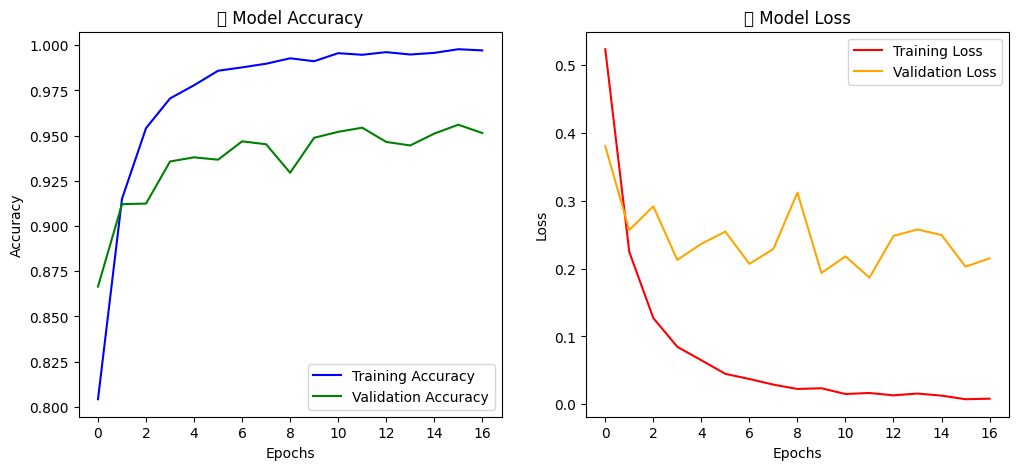

In [10]:

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('📈 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('📉 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### 🔹 Step 6: Extracting True Labels and Predictions
Here, I extracted the true class labels and predicted values from the test dataset. This is essential for evaluating the model using performance metrics.


In [11]:
labels = []
predictions = []
for x,y in test_generator:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

1/1 [==============================] - 2s 2s/step
Train Accuracy  : 99.72 %
Test Accuracy   : 95.44 %
Precision Score : 95.44 %
Recall Score    : 95.44 %


### 🔹 Step 7: Generating Confusion Matrix
In this step, I created a confusion matrix to visualize how well the model classified each tumor category. This helps in identifying misclassifications and model reliability.


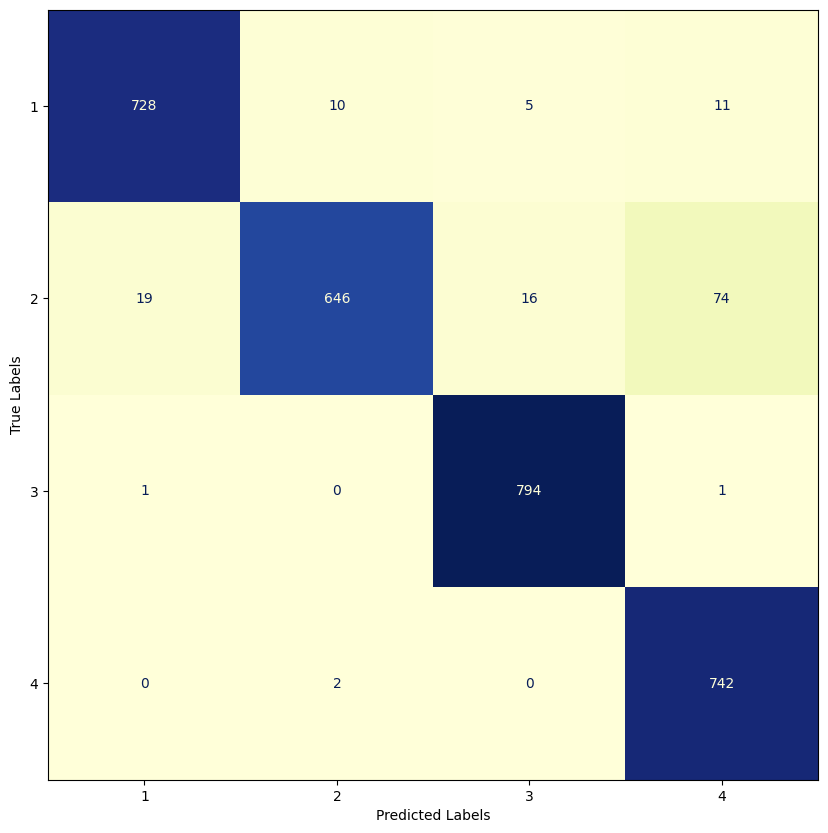

In [12]:
cm=confusion_matrix(labels,predictions)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=(list(range(1,5))))
fig, ax = plt.subplots(figsize=(15,10))
disp.plot(ax=ax, colorbar=False, cmap='YlGnBu')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 🔹 Step 10: Saving the Trained Model
In this step, I saved the trained deep learning model as a `.h5` file. This allows the model to be reused later for real-time prediction or deployment in a web application.


In [13]:
model.save("brain_cancer_model_efficent.h5")

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 🔹 Step 13: Image Preprocessing with OpenCV
In this step, I used OpenCV to load, resize, and preprocess MRI images before feeding them into the trained CNN model.


In [14]:
model.input_shape

(None, 256, 256, 3)

In [15]:
import tensorflow as tf
import tf2onnx

model = tf.keras.models.load_model("brain_cancer_model_efficent.h5")

spec = (tf.TensorSpec((1, 256, 256, 3), tf.float32, name="input"),)

output_path = "model2.onnx"
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)

print("Conversion complete! Saved as model.onnx")


Conversion complete! Saved as model.onnx


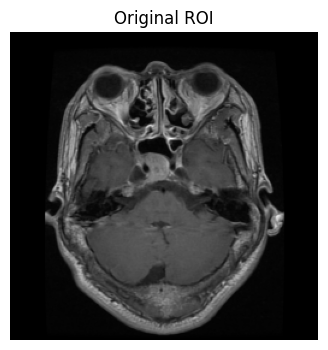

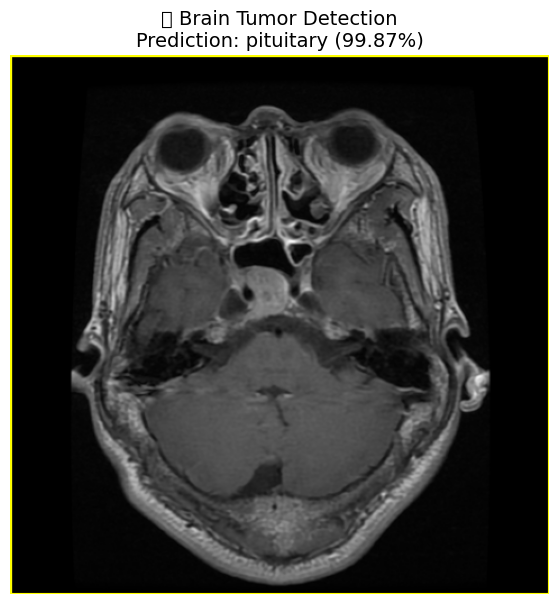

🧩 Predicted Tumor Type: pituitary
📊 Confidence: 99.87%


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load trained model
model = load_model("brain_cancer_model_efficent.h5")

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# ---------------- LOAD IMAGE ---------------- #

img_path = r"C:\Users\Acer\OneDrive\Documents\Datasets\tumor\Training\pituitary\00406.png"
frame = cv2.imread(img_path)

if frame is None:
    raise FileNotFoundError("❌ Image not found. Check path!")

frame = cv2.resize(frame, (480, 480))
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

_, thress = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

contours, _ = cv2.findContours(thress, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

detected_label = None
detected_conf = 0

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w * h < 500:
        continue

    roi = frame[y:y + h, x:x + w]
    resized_roi = cv2.resize(roi, (256, 256))
    roi_array = img_to_array(resized_roi)
    roi_array = preprocess_input(roi_array)
    roi_array = np.expand_dims(roi_array, axis=0)

    prediction = model.predict(roi_array, verbose=0)
    class_id = np.argmax(prediction)
    class_label = class_names[class_id]
    confidence = prediction[0][class_id] * 100

    detected_label = class_label
    detected_conf = confidence

    # -------- Grad-CAM -------- #
    
    # Draw bounding box
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
    cv2.putText(frame, f"{class_label} ({confidence:.2f}%)",
                (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                (255, 0, 255), 2)

    # Show Grad-CAM visualization
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.title("Original ROI")
    plt.imshow(cv2.cvtColor(resized_roi, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()


# If no contour detected
if detected_label is None:
    img_resized = cv2.resize(frame, (256, 256))
    img_array = img_to_array(img_resized)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)
    class_id = np.argmax(prediction)
    detected_label = class_names[class_id]
    detected_conf = prediction[0][class_id] * 100


# Final display
plt.figure(figsize=(7, 7))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title(f"🧠 Brain Tumor Detection\nPrediction: {detected_label} ({detected_conf:.2f}%)", fontsize=14)
plt.axis("off")
plt.show()

print(f"🧩 Predicted Tumor Type: {detected_label}")
print(f"📊 Confidence: {detected_conf:.2f}%")
